# CNN Model for 2x2 Jigsaw

### 1. Setup

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import MaxPooling1D, Conv1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Input, Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.layers import TimeDistributed as td
%load_ext autoreload
%autoreload 2

### 2. Prepare the data (Train, Valid, Test)

In [2]:
train_path = "E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/train/"
val_path = "E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/valid/"
test_path = "E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/test/"

Load Training Dataset

In [3]:
# Load Training Dataset
data_train = []
label_train = []
label_train_onehot = []

df_train = pd.read_csv(r"E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/train.csv", header = 0)
for i in range(90000): # df_train.shape[0]
    img_name = df_train['image'][i]
    img = plt.imread(train_path + img_name)
    img_split = []
    img_split.append(img[:100,:100,:].reshape(1,100,100,3))
    img_split.append(img[:100,100:,:].reshape(1,100,100,3))
    img_split.append(img[100:,:100,:].reshape(1,100,100,3))
    img_split.append(img[100:,100:,:].reshape(1,100,100,3))
    img_split = np.concatenate(img_split, axis=0)
    data_train.append(img_split.reshape(1,4,100,100,3))
    
    label = df_train['label'][i].split()
    label = [int(i) for i in label]
    label_train.append(np.array(label).reshape(1,4))
    #label_train_onehot.append(np.eye(4)[label].reshape(1, 4, 4))

data_train = np.concatenate(data_train, axis=0)
#data_train_norm = normalize(data_train, axis=1, norm='max')
label_train = np.concatenate(label_train, axis=0)

print("training data: ", data_train.shape)
print("training label: ", label_train.shape)

training data:  (90000, 4, 100, 100, 3)
training label:  (90000, 4)


Load Validation Dataset

In [4]:
# Load Validation Dataset
data_val = []
label_val = []
label_val_onehot = []
df_val = pd.read_csv(r"E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/valid.csv", header = 0)

for i in range(90000, 92000):
    img_name = df_train['image'][i]
    img = plt.imread(train_path + img_name)
    img_split = []
    img_split.append(img[:100,:100,:].reshape(1,100,100,3))
    img_split.append(img[:100,100:,:].reshape(1,100,100,3))
    img_split.append(img[100:,:100,:].reshape(1,100,100,3))
    img_split.append(img[100:,100:,:].reshape(1,100,100,3))
    img_split = np.concatenate(img_split, axis=0)
    data_val.append(img_split.reshape(1,4,100,100,3))
    
    label = df_train['label'][i].split()
    label = [int(i) for i in label]
    label_val.append(np.array(label).reshape(1,4))
    #label_val_onehot.append(np.eye(4)[label].reshape(1, 4, 4))

data_val = np.concatenate(data_val, axis=0)
label_val = np.concatenate(label_val, axis=0)

print("validation data: ", data_val.shape)
print("validation label: ", label_val.shape)

validation data:  (2000, 4, 100, 100, 3)
validation label:  (2000, 4)


Load Testing Dataset

In [5]:
# Load Testing Dataset
data_test = []
label_test = []
label_test_onehot = []
df_test = pd.read_csv(r"E:/Stanford_Spring_2122/CS229/Final_Project/data/puzzle_2x2/test.csv", header = 0)

for i in range(df_test.shape[0]):
    img_name = df_test['image'][i]
    img = plt.imread(test_path + img_name)
    img_split = []
    img_split.append(img[:100,:100,:].reshape(1,100,100,3))
    img_split.append(img[:100,100:,:].reshape(1,100,100,3))
    img_split.append(img[100:,:100,:].reshape(1,100,100,3))
    img_split.append(img[100:,100:,:].reshape(1,100,100,3))
    img_split = np.concatenate(img_split, axis=0)
    data_test.append(img_split.reshape(1,4,100,100,3))
    
    label = df_test['label'][i].split()
    label = [int(i) for i in label]
    label_test.append(np.array(label).reshape(1,4))
    #label_test_onehot.append(np.eye(4)[label].reshape(1, 4, 4))

data_test = np.concatenate(data_test, axis=0)
label_test = np.concatenate(label_test, axis=0)

print("testing data: ", data_test.shape)
print("testing label: ", label_test.shape)

testing data:  (2176, 4, 100, 100, 3)
testing label:  (2176, 4)


Show some example training images and their labels.

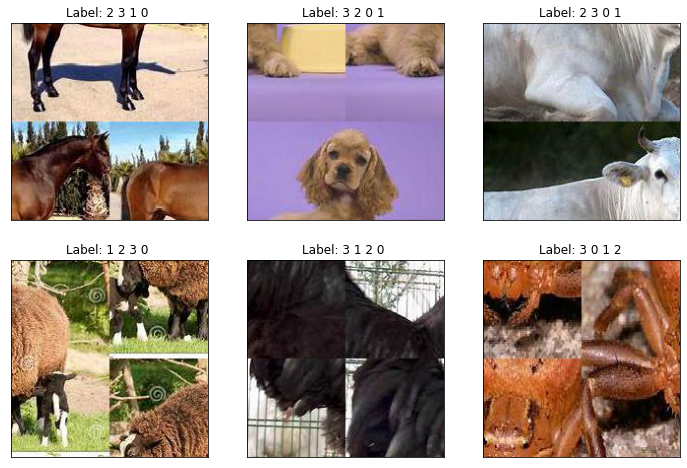

In [6]:
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Label: " + df_train['label'][i])
    plt.subplots_adjust(wspace=None, hspace=None)
    
    img_name = df_train['image'][i]
    img = plt.imread(train_path + img_name)
    plt.imshow(img)
plt.show()

### 3. Set Hyperparameters for CNN Model

In [7]:
lr = 0.001 # learning rate
decay = 1e-5 # learning rate decay
epochs = 10
batch_size = 128

input_shape = (4, 100, 100, 3)
dropout_rate = 0.3

### 4. Build the CNN Model

In [8]:
# Initiate a Keras sequential model
model = keras.models.Sequential()

# Feature Extractor
model.add(td(ZeroPadding2D(2), input_shape=input_shape))
model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
model.add(td(BatchNormalization()))
model.add(td(MaxPooling2D()))

model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
model.add(td(BatchNormalization()))
model.add(td(Dropout(dropout_rate)))

model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
model.add(td(BatchNormalization()))
model.add(td(Dropout(dropout_rate)))

model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
model.add(td(BatchNormalization()))
model.add(td(Dropout(dropout_rate)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(600, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(16))
model.add(Reshape((4, 4)))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 104, 104, 3)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 52, 52, 50)     3800      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 52, 52, 50)     200       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 26, 26, 50)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 13, 13, 100)    125100    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4, 13, 13, 100)    400       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4, 13, 13, 100)    0

### 5. Training the CNN Model

Training

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(data_train,
                    label_train, 
                    epochs=epochs, batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(data_val, label_val))

Epoch 1/10
704/704 [==============================] - 805s 1s/step - loss: 0.9488 - accuracy: 0.6084 - val_loss: 0.6615 - val_accuracy: 0.7149
Epoch 2/10
704/704 [==============================] - 837s 1s/step - loss: 0.5646 - accuracy: 0.7669 - val_loss: 0.5305 - val_accuracy: 0.7772
Epoch 3/10
704/704 [==============================] - 835s 1s/step - loss: 0.4223 - accuracy: 0.8293 - val_loss: 0.3871 - val_accuracy: 0.8451
Epoch 4/10
704/704 [==============================] - 820s 1s/step - loss: 0.3211 - accuracy: 0.8723 - val_loss: 0.4097 - val_accuracy: 0.8382
Epoch 5/10
704/704 [==============================] - 822s 1s/step - loss: 0.2452 - accuracy: 0.9040 - val_loss: 0.2952 - val_accuracy: 0.8845
Epoch 6/10
704/704 [==============================] - 843s 1s/step - loss: 0.1919 - accuracy: 0.9263 - val_loss: 0.2127 - val_accuracy: 0.9199
Epoch 7/10
704/704 [==============================] - 838s 1s/step - loss: 0.1529 - accuracy: 0.9414 - val_loss: 0.2260 - val_accuracy: 0.9136

Save trained model as .h5

In [14]:
model.save("CNN_2x2_10epoch_split.h5")

Plot training result

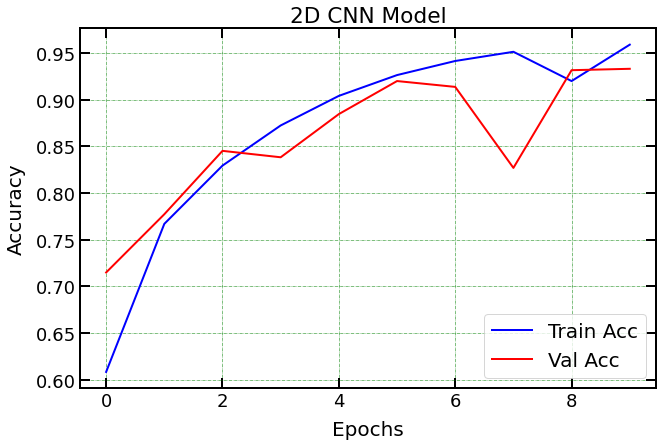

In [20]:
# Rebuild the matplotlib font cache
fm._rebuild()
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'DejaVu Sans' # font
plt.rcParams['font.size'] = 18         # font size
plt.rcParams['axes.linewidth'] = 2     # axes width

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])    # Add axes object to our figure that takes up entire figure
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
ax.plot(history.history["accuracy"], linewidth=2, color='b', label="Train Acc", alpha = 1)
ax.plot(history.history["val_accuracy"], linewidth=2, color='r', label="Val Acc", alpha = 1)
ax.set_ylabel('Accuracy', labelpad=10, fontsize=20)
ax.set_xlabel('Epochs', labelpad=10, fontsize=20)
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.legend(loc="lower right", fontsize=20)
plt.title("2D CNN Model")
plt.savefig('Figure7.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

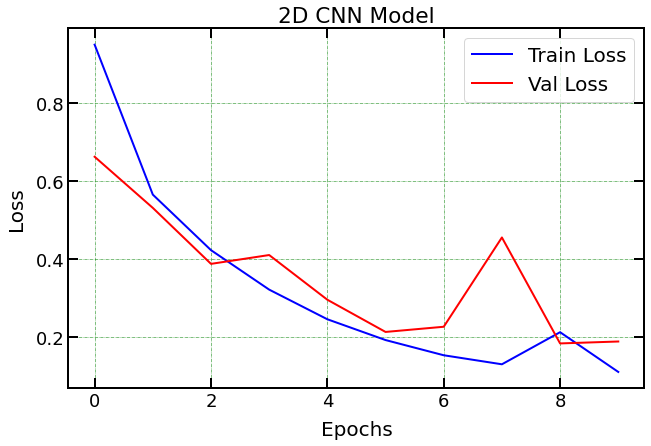

In [19]:
# Rebuild the matplotlib font cache
fm._rebuild()
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'DejaVu Sans' # font
plt.rcParams['font.size'] = 18         # font size
plt.rcParams['axes.linewidth'] = 2     # axes width

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])    # Add axes object to our figure that takes up entire figure
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
ax.plot(history.history["loss"], linewidth=2, color='b', label="Train Loss", alpha = 1)
ax.plot(history.history["val_loss"], linewidth=2, color='r', label="Val Loss", alpha = 1)
ax.set_ylabel('Loss', labelpad=10, fontsize=20)
ax.set_xlabel('Epochs', labelpad=10, fontsize=20)
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.legend(loc="upper right", fontsize=20)
plt.title("2D CNN Model")
plt.savefig('Figure8.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

### 6. Evaluation

Accuracy on test set

In [21]:
model_loaded = keras.models.load_model("CNN_2x2_10epoch_split.h5")
outputs = model_loaded.predict(data_test)
predictions = np.argmax(outputs, axis=2)

compare = (predictions == label_test)
num_correct = np.sum(np.all(compare, axis=1))
print(f"Accuracy on Test Set = {round(num_correct / predictions.shape[0] * 100, 2)}%")

Accuracy on Test Set = 84.1%


Example prediction

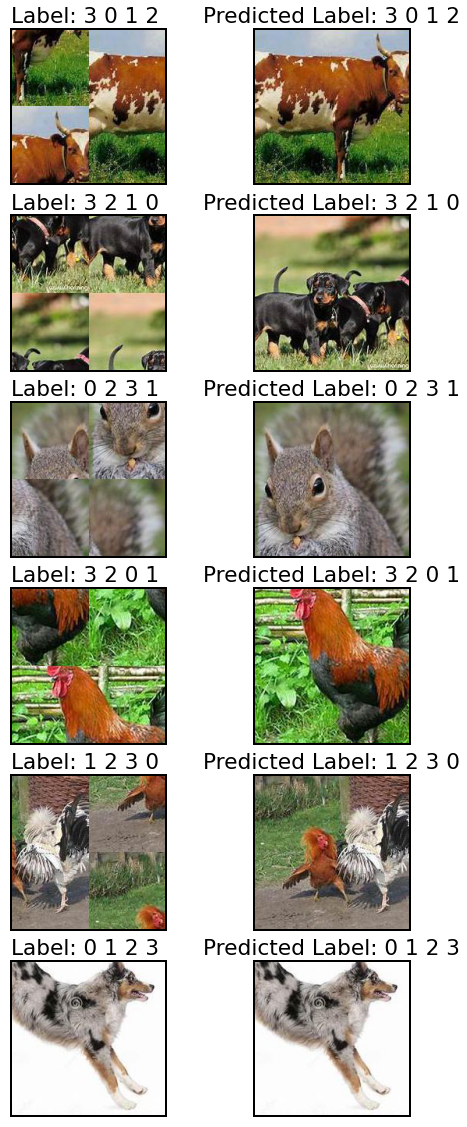

In [22]:
from util import rearrange

plt.figure(figsize=(8, 20))
for i in range(6):
    plt.subplot(6, 2, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Label: " + df_test['label'][i])
    plt.subplots_adjust(wspace=None, hspace=None)
    img_name = df_test['image'][i]
    img = plt.imread(test_path + img_name)
    plt.imshow(img)
    
    plt.subplot(6, 2, 2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    predicted_label = ""
    for a in predictions[i]:
        predicted_label += " " + str(a)
    plt.title("Predicted Label:" + predicted_label)
    plt.subplots_adjust(wspace=None, hspace=None)
    img_name = df_train['image'][i]
    plt.imshow(rearrange(predictions[i], data_test[i]).astype(int))
plt.show()